In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/HT1018

/content/drive/My Drive/HT1018


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov 17 05:40:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [5]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from usr_encoder import USREncoder
from logit import Out
import matplotlib.pyplot as plt
import random
import os
import math


def set_random_seed(seed = 10,deterministic=False,benchmark=False):
    random.seed(seed)
    np.random.random(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
    if benchmark:
        torch.backends.cudnn.benchmark = True
    return    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_flag = False  #测试标志，True时加载保存好的模型进行测试 
filename = './N20K2M32L8_Layer2_em128'
path_checkpoint = filename+'/ckpt_best_0.pth'  # 断点路径


EMx = 128
EMy = 128
EM = 128
N = 20
K = 2
L = 8
J = 0
M = 32
D = 500
FF = 512
txPower = 23 # dBm
noisePower = -99 # dBm
set_random_seed(10)

location = 'control'
channel = 'iid'
use_cov = True
sigma2s = np.ones([N,1])  
txPowerN = 0
noisePowerN = noisePower + 15.3 + 37.6*np.log10(D*math.tan(math.pi/6)) - txPower
matrx_Type = 'Gaussian'
VSIZE = 512
BSIZE = 256
TSIZE = 5000
if location =='uniform':
    NodeSIZE = 2*L+1
else:
    NodeSIZE = 2*L    
BNUM = 5000
EP = 120

#ma = torch.eye(N).to(device)
#mb = torch.ones(N).unsqueeze(0).to(device)
#ma = torch.cat((ma,mb),0)
#mc = torch.ones(N+1).unsqueeze(1).to(device)
#mask = ~torch.cat((ma,mc),1).bool()
mask = None

In [6]:
def sensingMatrixDesign(N,J,L,type):
    Ne = N*2**J
    if type=='Gaussian':
        A = (np.random.normal(loc=0, scale=1, size=(L, Ne))+1j*np.random.normal(loc=0, scale=1, size=(L, Ne)))*np.sqrt(0.5)
    else:
        raise NotImplementedError
    return A

In [7]:
def channelGeneration(N,M,sigma2s,channel):   

    if channel == 'noniid':
        Lp=2
        theta = np.random.uniform(low=-math.pi/6, high=math.pi/6, size=(N,Lp))
        alfa = np.sqrt(1/2)*(np.random.normal(loc=0, scale=1, size=(N, Lp)) + 1j*np.random.normal(loc=0, scale=1, size=(N, Lp)))
        a1=range(M)
        a2=1j*math.pi*np.sin(theta)
        a3=np.kron(a1,a2).reshape((N,Lp,M))
        a = np.exp(a3)
        hh=np.expand_dims(alfa,2).repeat(M,axis=2)*a
        H = hh.sum(axis=1)/np.sqrt(Lp)
    else:
        H = np.sqrt(1/2)*(np.random.normal(loc=0, scale=1, size=(N, M)) + 1j*np.random.normal(loc=0, scale=1, size=(N, M))) 

    H = np.sqrt(np.tile(sigma2s,(1,M)))*H # sigma2s large-scale fading component
    return H

In [8]:
def signalGeneration(N,K,L,J,M,H,txPowerMax,noisePower):
    user_idx = np.random.permutation(N)
    user_idx[0:K] = np.sort(user_idx[0:K])
    user_supp = np.zeros([N])
    user_supp[user_idx[0:K]] = 1

    # Data of active users  
    data_idx = np.random.randint(2**J,size=K) # the data indices for active users

    # Combined support
    supp = np.zeros([2**J*N])
    supp[user_idx[0:K]*2**J + data_idx] = 1

    # Signal generation 
    Ne = N*2**J
    Heff = np.repeat(H, 2**J, axis=0) # eff. channel; channel for sequences of one users are equal.
    x = np.zeros([Ne,M])+1j*np.zeros([Ne,M])
    x[(supp==1),:] = Heff[(supp==1),:] 

    # Noise setup with power control
    sigma2n = (10**((noisePower)/10)) 
    txPower = 10**(txPowerMax/10)
    sigma2n = sigma2n/txPower
    return x,user_supp,supp,user_idx,data_idx,sigma2n

In [9]:
def datasetGeneration(datasize,N,J,L,matrx_Type,M,K,txPowerN,noisePowerN,location,channel,use_cov):   
    if location=='uniform':
        A_data = np.zeros([datasize, N, 2*L+1])
    else: 
        A_data = np.zeros([datasize, N, 2*L])
    if use_cov == True:
        Cov_data = np.zeros([datasize, 2*L*L])
    else:
        Cov_data = np.zeros([datasize, 2*L*M])
    supp_data = np.zeros([datasize, N])
        
    for mc in range(datasize):

        # Sequence generation
        A = sensingMatrixDesign(N,J,L,matrx_Type)
    

        # if location=='uniform':
        #     distance = np.zeros([N,1])  
        #     x_Range = D*math.tan(math.pi/6)*3/2
        #     y_Range = D
          
        #     for iUE in range(N):
        #         RD = 0
        #         while RD<=50:
        #             x_Posi = np.random.uniform(x_Range*(-2/3), x_Range*(1/3))
        #             y_Posi = np.random.uniform(y_Range*(-1/2), y_Range*(1/2))

        #             if y_Posi > x_Posi*math.tan(math.pi/3)+D:
        #                 x_Posi = x_Posi+x_Range
        #                 y_Posi = y_Posi-y_Range/2
        #             elif y_Posi < -x_Posi*math.tan(math.pi/3)-D:
        #                 x_Posi = x_Posi+x_Range
        #                 y_Posi = y_Posi+y_Range/2

        #             RD = np.sqrt(x_Posi**2 + y_Posi**2)
        #         distance[iUE,0]=RD

        #     sigma2dB = 128-15.3-37.6*np.log10(distance)
        #     sigma2s = 10**(sigma2dB/10)   
            

        # Gaussian channel
        H = channelGeneration(N,M,sigma2s,channel)
        

        # Sparse signal
        x,user_supp,supp,user_idx,data_idx,sigma2n = signalGeneration(N,K,L,J,M,H,txPowerN,noisePowerN)

        # Additive noise
        w = np.sqrt(1/2)*(np.random.normal(loc=0, scale=1, size=(L,M))+1j*np.random.normal(loc=0, scale=1, size=(L,M)))*np.sqrt(sigma2n)

        # System model
        y = np.dot(A,x)+ w
        if use_cov == True:        
            Cov = 1/M*np.dot(y,y.T.conj()).reshape(-1)
        else:
            Cov = y.reshape(-1)    

        
        Cov_data[mc,:] = np.hstack((np.real(Cov), np.imag(Cov)))
        supp_data[mc,:] = supp

        if location=='uniform':
            A_data[mc,:,:-1] = np.vstack((np.real(A), np.imag(A))).T
            A_data[mc,:,-1] = np.squeeze(distance)
        else:
            A_data[mc,:,:] = np.vstack((np.real(A), np.imag(A))).T  

    dA = torch.FloatTensor(A_data).to(device)
    dCov = torch.FloatTensor(Cov_data).to(device)
    dsupp = torch.FloatTensor(supp_data).to(device)
    
    return dA, dCov, dsupp 

In [10]:
vA, vCov, vsupp = datasetGeneration(VSIZE,N,J,L,matrx_Type,M,K,txPowerN,noisePowerN,location,channel,use_cov)

In [11]:
class SAD(nn.Module):
    def __init__(self,L,EMx,EMy,EM,FF,NodeSIZE):
        super(SAD,self).__init__()
        
        if use_cov == True:
            # self.cov = torch.nn.Sequential(
            #      nn.Linear(2*L*L, FF),
            #      nn.ReLU(),
            #      nn.Linear(FF, EMy)
            #    )
            self.cov = nn.Linear(2*L*L, EMy)
        else:
            self.cov = nn.Linear(2*L*M, EMy)

                
        self.usr1 = USREncoder(
            n_heads=8,
            embed_dim=EM,
            y_dim=EMy,
            x_dim=EMx, 
            feed_forward_hidden = FF,
            node_dim = NodeSIZE,
            normalization='batch'
                       )    
        
        self.usr2 = USREncoder(
            n_heads=8,
            embed_dim=EM,
            y_dim=EMy,
            x_dim=EMx,
            feed_forward_hidden = FF,
            normalization='batch'
                       )
        
        # self.usr3 = USREncoder(
        #     n_heads=8,
        #     embed_dim=EM,
        #     y_dim=EMy,
        #     x_dim=EMx, 
        #     feed_forward_hidden = FF,
        #     normalization='batch'
        #                )
     
        # self.usr4 = USREncoder(
        #      n_heads=8,
        #      embed_dim=EM,
        #      y_dim=EMy,
        #      x_dim=EMx, 
        #      feed_forward_hidden = FF,
        #      normalization='batch'
        #                 )
             
        # self.usr5 = USREncoder(
        #      n_heads=8,
        #      embed_dim=EM,
        #      y_dim=EMy,
        #      x_dim=EMx, 
        #      feed_forward_hidden = FF,
        #      normalization='batch'
        #                 )
      
        # self.usr6 = USREncoder(
        #      n_heads=8,
        #      embed_dim=EM,
        #      y_dim=EMy,
        #      feed_forward_hidden = FF,
        #      normalization='batch'
        #                 )
        
       # self.usr7 = USREncoder(
       #     n_heads=8,
       #     embed_dim=EM,
       #     y_dim=EMy,
       #     feed_forward_hidden = FF,
       #     normalization='batch'
      #                 )
        
       # self.usr8 = USREncoder(
       #     n_heads=8,
       #     embed_dim=EM,
       #     y_dim=EMy,
       #     feed_forward_hidden = FF,
       #     normalization='batch'
       #                )    
        
        self.out = Out(
            n_heads=8,
            embed_dim=EM,
            y_dim=EMy,
            x_dim=EMx
                 )
         
    def forward(self,x,y,mask):
        y = self.cov(y).unsqueeze(1)
        x, y = self.usr1(x,y,mask)      
        x, y = self.usr2(x,y,mask)      
        # x, y = self.usr3(x,y,mask)      
        # x, y = self.usr4(x,y,mask)      
        # x, y = self.usr5(x,y,mask)      
        # x, y = self.usr6(x,y,mask) 
      #  x, y = self.usr7(x,y,mask)  
      #  x, y = self.usr8(x,y,mask)       
        output = self.out(x,y)
        return output

In [12]:
model = SAD(L,EMx,EMy,EM,FF,NodeSIZE).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([(N-K)/K]).to(device))
#criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_schedule = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[90,97],gamma=0.1)

if test_flag:
    checkpoint = torch.load(path_checkpoint, map_location=torch.device(device))  # 加载断点
    model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
    optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
    start_epoch = checkpoint['epoch']  # 设置开始的epoch
    lr_schedule.load_state_dict(checkpoint['lr_schedule'])
  #  lr_schedule = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[90,97],gamma=0.1,last_epoch=0)

    print('Load epoch {} successfully'.format(start_epoch))
else:
    start_epoch = -1
    print('From epoch 0')

From epoch 0


In [13]:
for epoch in range(start_epoch+1, EP):
    model.train()
    train_loss = 0
    for i in range(BNUM):  
        bA, bCov, bsupp = datasetGeneration(BSIZE,N,J,L,matrx_Type,M,K,txPowerN,noisePowerN,location,channel,use_cov)
        optimizer.zero_grad()   
        logit = model(bA,bCov,mask)
        loss = criterion(logit, bsupp)
        loss.backward()
        optimizer.step()  
        train_loss += (2*K/N)*loss.item()
    loss_mean = train_loss / BNUM
    print('Train Epoch: {}\t Loss: {:.6f}'.format(epoch, loss_mean))    
        
    model.eval() 
    with torch.no_grad():
        #vA, vCov, vsupp = bA, bCov, bsupp 
        vlogit = model(vA,vCov,mask)
        vloss = criterion(vlogit, vsupp).item()
        vprob = torch.sigmoid(vlogit)
        vpred = torch.zeros(vprob.size()).to(device)
        vpred[vprob>=0.5]=1
        err = N*VSIZE-(vpred==vsupp).sum().sum().item()

    print('Test set: Loss: {:.4f}, Error rate: {}/{} ({:.2f}%)'.format((2*K/N)*vloss, err, N*VSIZE, 100. * err/N/VSIZE)) 
    print('learning rate:',optimizer.state_dict()['param_groups'][0]['lr'])
    print('\n')  

    lr_schedule.step()

    checkpoint = {
        'net': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'lr_schedule': lr_schedule.state_dict()
    }
    if not os.path.isdir(filename):
        os.mkdir(filename)
    torch.save(checkpoint, filename+'/ckpt_best_%s.pth' % (str(epoch)))

Train Epoch: 0	 Loss: 0.114483
Test set: Loss: 0.0504, Error rate: 595/10240 (5.81%)
learning rate: 0.0001


Train Epoch: 1	 Loss: 0.035990
Test set: Loss: 0.0251, Error rate: 268/10240 (2.62%)
learning rate: 0.0001


Train Epoch: 2	 Loss: 0.020265
Test set: Loss: 0.0165, Error rate: 197/10240 (1.92%)
learning rate: 0.0001


Train Epoch: 3	 Loss: 0.013453
Test set: Loss: 0.0121, Error rate: 137/10240 (1.34%)
learning rate: 0.0001


Train Epoch: 4	 Loss: 0.009761
Test set: Loss: 0.0091, Error rate: 104/10240 (1.02%)
learning rate: 0.0001


Train Epoch: 5	 Loss: 0.007431
Test set: Loss: 0.0069, Error rate: 90/10240 (0.88%)
learning rate: 0.0001


Train Epoch: 6	 Loss: 0.005787
Test set: Loss: 0.0046, Error rate: 72/10240 (0.70%)
learning rate: 0.0001


Train Epoch: 7	 Loss: 0.004682
Test set: Loss: 0.0042, Error rate: 62/10240 (0.61%)
learning rate: 0.0001


Train Epoch: 8	 Loss: 0.003841
Test set: Loss: 0.0030, Error rate: 46/10240 (0.45%)
learning rate: 0.0001


Train Epoch: 9	 Loss: 0

In [14]:
tA, tCov, tsupp = datasetGeneration(TSIZE,N,J,L,matrx_Type,M,K,txPowerN,noisePowerN,location,channel,use_cov)

import time
start = time.time()
model.eval() 
with torch.no_grad():
    tlogit = model(tA,tCov,mask)
    tprob = torch.sigmoid(tlogit)
end = time.time()
print('time=', end-start)

time= 0.0067596435546875


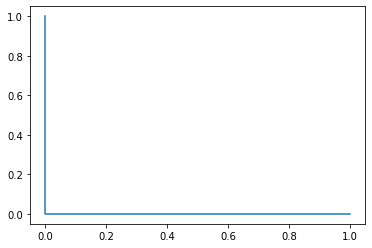

In [15]:
NUM = 200
min_g = tprob[tprob>0].min().item()
max_g = tprob.max().item()
set_1 = np.exp(np.linspace(np.log(min_g*0.95),np.log(max_g*1.05),int(NUM/2)))
set_2 = np.linspace(min_g*0.95,max_g*1.05,int(NUM/2))
TH = np.sort(np.concatenate((set_1,set_2)))
pm_cov = np.zeros([NUM,1])
pf_cov = np.zeros([NUM,1])

for idx in range(NUM):
    th = TH[idx]
    th_supp = np.zeros(tsupp.size())
    th_supp[(tprob>=th).cpu()]=1
    detect = th_supp*(tsupp.cpu().numpy())
    pm_cov[idx] = 1-detect.sum()/K/TSIZE
    falarm = th_supp-detect
    pf_cov[idx] = falarm.sum()/(N-K)/TSIZE 

plt.plot(pm_cov, pf_cov)  
plt.show()  

In [16]:
pm_cov.tolist()

[[0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],


In [17]:
pf_cov.tolist()

[[1.0],
 [1.0],
 [0.011322222222222223],
 [0.005733333333333333],
 [0.003933333333333334],
 [0.003],
 [0.0021444444444444445],
 [0.0018333333333333333],
 [0.0016],
 [0.001377777777777778],
 [0.0011777777777777778],
 [0.0011],
 [0.0009555555555555555],
 [0.0008444444444444444],
 [0.0008222222222222221],
 [0.0007888888888888889],
 [0.000711111111111111],
 [0.000688888888888889],
 [0.0006222222222222223],
 [0.0006],
 [0.0005777777777777778],
 [0.0005444444444444445],
 [0.0005444444444444445],
 [0.000488888888888889],
 [0.0004666666666666667],
 [0.0004333333333333333],
 [0.00041111111111111106],
 [0.00038888888888888887],
 [0.00038888888888888887],
 [0.00036666666666666667],
 [0.0003555555555555555],
 [0.0003222222222222222],
 [0.0002888888888888889],
 [0.0002777777777777778],
 [0.00025555555555555553],
 [0.0002444444444444445],
 [0.00022222222222222223],
 [0.00022222222222222223],
 [0.00022222222222222223],
 [0.00022222222222222223],
 [0.0002111111111111111],
 [0.0002],
 [0.00018888888888

In [18]:
# tA=tA.cpu()
# tCov=tCov.cpu()
# tsupp=tsupp.cpu()
# tprob=tprob.cpu()
# SAM=1280
# num=0
# samp = torch.zeros([TSIZE,N,SAM])
# for sam in range(SAM):
#     samp[:,:,sam] = tprob.bernoulli()
# R=torch.zeros(TSIZE,SAM)
# sigma2W = (10**((noisePowerN)/10))*torch.eye(L)
# for idx in range(TSIZE):
#     CA = tA[idx,:,:].T[:L,:]+1j*tA[idx,:,:].T[L:,:]
#     CAT = tA[idx,:,:L]-1j*tA[idx,:,L:]
#     CCov = (tCov[idx,:L**2]+1j*tCov[idx,L**2:]).reshape(L,L)
#     for sam in range(SAM):
#         DD = torch.diag(samp[idx,:,sam])
#         CD = DD+1j*torch.zeros(DD.size())
#         SIGMA =torch.mm(torch.mm(CA, CD), CAT)+sigma2W
#         R[idx,sam] = torch.det(SIGMA).abs().log()+torch.trace(torch.mm(SIGMA.inverse(), CCov)).real
# for SAM in [320,640,960,1280]:
#   r = R[:,:SAM]
#   s = samp[:,:,:SAM]
#   bestsamp = r.min(1)[1]
#   choice = s[[i for i in range(TSIZE)],:,bestsamp]
#   err = N*TSIZE-(choice.numpy()==tsupp.numpy()).sum().sum().item()
#   detect = choice.numpy()*tsupp.numpy()
#   pm=1-detect.sum()/K/TSIZE
#   falarm = choice.numpy()-detect
#   pf=falarm.sum()/(N-K)/TSIZE     
#   print('Results: Sampling number: {}\t, Error rate: {}/{} ({:.2f}%)\n'.format(SAM, err, N*TSIZE, 100. * err/N/TSIZE))  
#   print('Probability of missed detection: {:.4f}, Probability of false alarm: {:.4f}\n'.format(pm,pf))  
 

In [19]:
N=120
K=int(N/10)
M=64
sigma2s = np.ones([N,1])  
Pmax=23
noisePowerN = -14.188607425695352+(23-Pmax) 
tA, tCov, tsupp = datasetGeneration(TSIZE,N,J,L,matrx_Type,M,K,txPowerN,noisePowerN,location,channel,use_cov)

import time
start = time.time()
model.eval() 
with torch.no_grad():
    tlogit = model(tA,tCov,mask)
    tprob = torch.sigmoid(tlogit)
end = time.time()
print('time=', end-start)

time= 0.01679706573486328


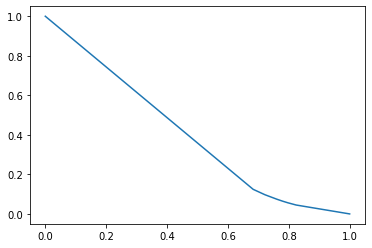

In [20]:
NUM = 200
min_g = tprob[tprob>0].min().item()
max_g = tprob.max().item()
set_1 = np.exp(np.linspace(np.log(min_g*0.95),np.log(max_g*1.05),int(NUM/2)))
set_2 = np.linspace(min_g*0.95,max_g*1.05,int(NUM/2))
TH = np.sort(np.concatenate((set_1,set_2)))
pm_cov = np.zeros([NUM,1])
pf_cov = np.zeros([NUM,1])

for idx in range(NUM):
    th = TH[idx]
    th_supp = np.zeros(tsupp.size())
    th_supp[(tprob>=th).cpu()]=1
    detect = th_supp*(tsupp.cpu().numpy())
    pm_cov[idx] = 1-detect.sum()/K/TSIZE
    falarm = th_supp-detect
    pf_cov[idx] = falarm.sum()/(N-K)/TSIZE 

plt.plot(pm_cov, pf_cov)  
plt.show()  

In [21]:
pm_cov.tolist()

[[0.0],
 [0.0],
 [0.6829833333333333],
 [0.7051000000000001],
 [0.7154],
 [0.7215333333333334],
 [0.7271333333333334],
 [0.7313833333333333],
 [0.7349666666666667],
 [0.7379166666666667],
 [0.7409833333333333],
 [0.7433833333333333],
 [0.7454833333333333],
 [0.7474333333333334],
 [0.7491666666666666],
 [0.7506333333333334],
 [0.7521166666666667],
 [0.7533333333333334],
 [0.7545999999999999],
 [0.7558],
 [0.7567833333333334],
 [0.7581333333333333],
 [0.7589666666666667],
 [0.7601833333333333],
 [0.7612333333333333],
 [0.7621333333333333],
 [0.76295],
 [0.7640833333333333],
 [0.7651],
 [0.7658],
 [0.76635],
 [0.7670333333333333],
 [0.7679333333333334],
 [0.7686999999999999],
 [0.7695333333333334],
 [0.7703166666666666],
 [0.7709333333333334],
 [0.7716333333333334],
 [0.7721833333333333],
 [0.7727166666666667],
 [0.7732],
 [0.7737666666666667],
 [0.7744666666666666],
 [0.7750666666666667],
 [0.7756000000000001],
 [0.7762166666666667],
 [0.77675],
 [0.7773166666666667],
 [0.777816666666666

In [22]:
pf_cov.tolist()

[[1.0],
 [1.0],
 [0.12435185185185185],
 [0.10840740740740741],
 [0.10147222222222221],
 [0.09710925925925926],
 [0.09393888888888889],
 [0.0914611111111111],
 [0.08936481481481481],
 [0.0875574074074074],
 [0.08604814814814815],
 [0.0846611111111111],
 [0.0834037037037037],
 [0.08232407407407408],
 [0.08131111111111111],
 [0.08045],
 [0.07956666666666666],
 [0.07875925925925926],
 [0.07797777777777778],
 [0.0772962962962963],
 [0.07658888888888889],
 [0.07592592592592592],
 [0.0753074074074074],
 [0.07473518518518518],
 [0.07417777777777779],
 [0.07367962962962964],
 [0.07320925925925927],
 [0.07276851851851852],
 [0.07232592592592592],
 [0.07188703703703703],
 [0.0714925925925926],
 [0.07109074074074073],
 [0.07067592592592592],
 [0.07027962962962964],
 [0.0699074074074074],
 [0.06956851851851852],
 [0.06919074074074073],
 [0.06885555555555556],
 [0.06851851851851852],
 [0.0681962962962963],
 [0.06785740740740741],
 [0.06754444444444445],
 [0.0672537037037037],
 [0.06696481481481481]